list of techniques [here](https://blog.floydhub.com/ten-techniques-from-fast-ai/)

In [2]:
import torch
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import transforms
import torchvision
import copy

%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1)

In [74]:
transform = transforms.Compose([
#                                    transforms.RandomAffine(15, scale=(.9,1.2)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,), (1,))
                               ])
mnist_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
data_loader_train = DataLoader(mnist_trainset, 64, shuffle=True, num_workers=8)
data_loader_test = DataLoader(mnist_testset, 64, shuffle=True, num_workers=8)

Files already downloaded and verified


In [75]:
import RestNet
model = RestNet.ResNet18().to(device)
criterion = F.cross_entropy

In [52]:
# model = torchvision.models.resnet18(pretrained=True)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 10)
# model = model.to(device)

### Find learning rate

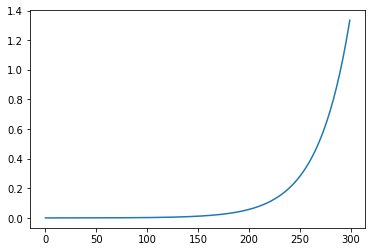

In [7]:
import math
lrs = []
for i in [x for x in range(300)]:
    lr = math.pow(1.1, i/3) / 10000
    lrs.append(lr)
plt.plot(lrs)

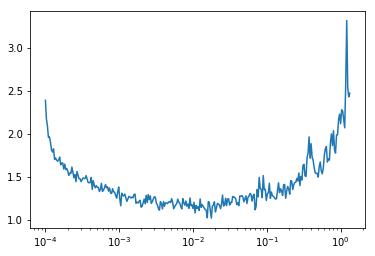

In [8]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
losses = []
model.train()
def is_running():
    return len(losses) < len(lrs)
count = 0
batch_num = 10
while is_running():
    for i, (data, target) in enumerate(data_loader_train):
        if count == 0:
            loss_accumulate = 0
            for param_group in optimizer.param_groups:
                param_group['lr'] = lrs[len(losses)]

        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        loss_accumulate += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if count == batch_num:
            losses.append(loss_accumulate/batch_num)
            count = -1
        if not is_running(): break
        count += 1
        
plt.semilogx(lrs, losses)

### Learning Rates [Choose one]
1. Different LR [worse] (maybe we have to use log scale)

In [60]:
lr = 0.001
num_children = len([c for c in model.children()])
param_groups = []
for i, child in enumerate(model.children()):
    denorm = num_children-i
    param_groups.append({
        'params': child.parameters(), 'lr': lr/denorm
    })
optimizer = optim.Adam(param_groups, lr=0.001, weight_decay=0.0) #weight_decay (L2 regularization) makes thing worse

In [61]:
for param_group in optimizer.param_groups:
    print(param_group['lr'])

0.00014285714285714287
0.00016666666666666666
0.0002
0.00025
0.0003333333333333333
0.0005
0.001


2. Static Learning Rate

In [76]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Train

In [11]:
def get_num_correct(output, target):
    # max of dimension 1, keepdim, and [0] is value / [1] is index (we need only index)
    pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    correct = pred.eq(target.view_as(pred)).sum().item()
    return correct

epoch: 0, i: 0, loss: 2.350830078125
epoch: 0, i: 100, loss: 1.5525232553482056
epoch: 0, i: 200, loss: 1.4310418367385864
epoch: 0, i: 300, loss: 1.5137114524841309
epoch: 0, i: 400, loss: 1.2138307094573975
epoch: 0, i: 500, loss: 1.1682647466659546
epoch: 0, i: 600, loss: 1.3540397882461548
epoch: 0, i: 700, loss: 0.8702763319015503
training set last batch acc: 52.04

Test set: Average loss: -3.4319, Accuracy: 6229/10000 (62.29%)

epoch: 1, i: 0, loss: 0.8547930121421814
epoch: 1, i: 100, loss: 0.750038743019104
epoch: 1, i: 200, loss: 0.8301748037338257
epoch: 1, i: 300, loss: 0.9035918116569519
epoch: 1, i: 400, loss: 0.7828261256217957
epoch: 1, i: 500, loss: 0.7730602025985718
epoch: 1, i: 600, loss: 0.8201462030410767
epoch: 1, i: 700, loss: 0.7080259323120117
training set last batch acc: 71.004

Test set: Average loss: -4.0504, Accuracy: 7426/10000 (74.26%)

epoch: 2, i: 0, loss: 0.8628064393997192
epoch: 2, i: 100, loss: 0.576935887336731
epoch: 2, i: 200, loss: 0.62910211086

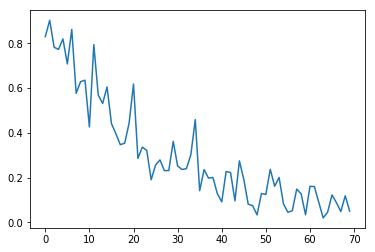

In [77]:
losses = []
def train(epoch):
    model.train()
    correct = 0
    for i, (data, target) in enumerate(data_loader_train):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i%100 == 0:
            print(f'epoch: {epoch}, i: {i}, loss: {loss.item()}')
            losses.append(loss.item())
            
        correct += get_num_correct(output, target)            
        if i == len(data_loader_train)-1:
            print(f'training set last batch acc: {100. * correct / len(data_loader_train.dataset)}')
def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in data_loader_test:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item() # sum up batch loss, default is mean
            correct += get_num_correct(output, target)
    test_loss /= len(data_loader_test.dataset)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(data_loader_test.dataset),
        100. * correct / len(data_loader_test.dataset)))
    
for epoch in range(10):
    train(epoch)
    test(epoch)
    
losses = losses[10:]
x_data = [i for i in range(len(losses))]
plt.plot(x_data, losses)    

with random rotate+zoom : train:100, test 83.31